In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.optim import lr_scheduler

## Layers

In [2]:
# Conv
class Conv2d(nn.Module):
    def __init__(self, nch_in, nch_out, kernel_size=4, stride=1, padding=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(nch_in, nch_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

    def forward(self, x):
        return self.conv(x)

# Linear
class Linear(nn.Module):
    def __init__(self, nch_in, nch_out, bias=True):
        super(Linear, self).__init__()
        self.linear = nn.Linear(nch_in, nch_out, bias)

    def forward(self, x):
        return self.linear(x)

# ReLU / LeakyReLU
class ReLU(nn.Module):
    def __init__(self, relu):
        super(ReLU, self).__init__()
        if relu > 0:
            self.relu = nn.LeakyReLU(relu, True)
        elif relu == 0:
            self.relu = nn.ReLU(True)

    def forward(self, x):
        return self.relu(x)

# Padding
class Padding(nn.Module):
    def __init__(self, padding, padding_mode='zeros', value=0):
        super(Padding, self).__init__()
        if padding_mode == 'reflection':
            self. padding = nn.ReflectionPad2d(padding)
        elif padding_mode == 'replication':
            self.padding = nn.ReplicationPad2d(padding)
        elif padding_mode == 'constant':
            self.padding = nn.ConstantPad2d(padding, value)
        elif padding_mode == 'zeros':
            self.padding = nn.ZeroPad2d(padding)

    def forward(self, x):
        return self.padding(x)

# Pooling (Avg / Max / Conv)
class Pooling2d(nn.Module):
    def __init__(self, nch=[], pool=2, type='avg'):
        super().__init__()

        if type == 'avg':
            self.pooling = nn.AvgPool2d(pool)
        elif type == 'max':
            self.pooling = nn.MaxPool2d(pool)
        elif type == 'conv':
            self.pooling = nn.Conv2d(nch, nch, kernel_size=pool, stride=pool)

    def forward(self, x):
        return self.pooling(x)

## STN 

Input : feature map

Output : warped input feature map (by affine transformation)

<br/>


`theta` 

- `parameters of the spatial transformer that should be applied to the feature map`

<br/>

`sampling grid` 

- `set of points where the input map should be sampled to produce the transformed output`

- `has x and y input pixel locations which are used to compute output`

- `done by grid generator`

In [3]:
# Classification Network 
# STN을 통과하여 spatial transform된 이미지를 입력으로 받아 class label 예측
class CLS(nn.Module):
    def __init__(self, nch_in, nch_out, nch_ker=64, norm='bnorm'):
        super(CLS, self).__init__()
        self.nch_in = nch_in
        self.nch_out = nch_out
        self.nch_ker = nch_ker
        self.norm = norm
        
        # Conv
        self.conv1 = Conv2d(self.nch_in, 10, kernel_size=5, stride=1, padding=0, bias=True)
        self.pool1 = Pooling2d(pool=2, type='max')
        self.relu1 = ReLU(0.0)

        self.conv2 = Conv2d(10, 20, kernel_size=5, stride=1, padding=0, bias=True)
        self.drop2 = nn.Dropout2d(0.5)
        self.pool2 = Pooling2d(pool=2, type='max')
        self.relu2 = ReLU(0.0)
        
        # F.C
        self.fc1 = Linear(nch_in=320, nch_out=50)
        self.relu_fc1 = ReLU(0.0)
        self.drop_fc1 = nn.Dropout2d(0.5)
        self.fc2 = Linear(nch_in=50, nch_out=10)

    def forward(self, x):
        # perform the usual forward pass
        x = self.relu1(self.pool1(self.conv1(x)))
        x = self.relu2(self.pool2(self.drop2(self.conv2(x))))

        x = x.view(-1, 320)

        x = self.drop_fc1(self.relu_fc1(self.fc1(x)))
        x = self.fc2(x)

        x = torch.log_softmax(x, dim=1)  # 최종 예측 label

        return x

In [4]:
class STN(nn.Module):
    def __init__(self, nch_in, nch_out, nch_ker=64, norm='bnorm'):
        super(STN, self).__init__()
        self.nch_in = nch_in
        self.nch_out = nch_out
        self.nch_ker = nch_ker
        self.norm = norm

        # Localization Network 
        localization = []
        localization += [Conv2d(nch_in=self.nch_in, nch_out=8, kernel_size=7, stride=1, padding=0, bias=True)]
        localization += [Pooling2d(pool=2, type='max')]
        localization += [ReLU(0.0)]

        localization += [Conv2d(nch_in=8, nch_out=10, kernel_size=5, stride=1, padding=0, bias=True)]
        localization += [Pooling2d(pool=2, type='max')]
        localization += [ReLU(0.0)]

        self.localization = nn.Sequential(*localization)

        # Regression Network 
        affinement = []
        affinement += [Linear(nch_in=10 * 3 * 3, nch_out=32)]
        affinement += [ReLU(0.0)]
        affinement += [Linear(nch_in=32, nch_out=2 * 3)]

        self.affinement = nn.Sequential(*affinement)

    def forward(self, x):  # x : [1, 1, 28, 28]
        # transform the input
        x_loc = self.localization(x)  # [1, 10, 3, 3]  
        x_loc = x_loc.view(-1, 10 * 3 * 3)  # [1, 90]
        
        # Transformation parameters
        theta = self.affinement(x_loc)  # [1, 6]
        theta = theta.view(-1, 2, 3)  # [2, 3]  
        
        # Parameterised sampling grid 
        grid = F.affine_grid(theta, x.size())  # (1, 28, 28, 2) - used to compute output
        x = F.grid_sample(x, grid)  # output (sampled from the input at the grid points)

        return x  

In [5]:
x = torch.randn([1, 1, 28, 28])
model = STN(1, 10)
out = model(x)
out.shape

C:\Users\Moon\Anaconda3\envs\iml\lib\site-packages\torch\nn\functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\Moon\Anaconda3\envs\iml\lib\site-packages\torch\nn\functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


torch.Size([1, 1, 28, 28])

In [6]:
# 초기화 메서드
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
    if gpu_ids:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net

## Dataset

In [7]:
import torch
import torch.nn as nn

import os
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from statistics import mean

In [10]:
import os
import numpy as np
import torch
from skimage import transform
import matplotlib.pyplot as plt


class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, data_type='float32', nch=1, transform=[]):
        self.data_dir = data_dir
        self.transform = transform
        self.nch = nch  # 이미지 채널
        self.data_type = data_type

        lst_data = os.listdir(data_dir)

        self.names = lst_data

    def __getitem__(self, index):
        data = plt.imread(os.path.join(self.data_dir, self.names[index]))[:, :, :self.nch]

        if data.dtype == np.uint8:
            data = data / 255.0

        if self.transform:
            data = self.transform(data)

        return data

    def __len__(self):
        return len(self.names)

# numpy -> tensor (참고: https://sanghyu.tistory.com/19)
class ToTensor(object):
    def __call__(self, data):
        # 단일 이미지
        if data.ndim == 3:
            data = data.transpose((2, 0, 1)).astype(np.float32)  # [h, w, c] -> [c, h, w]
        
        # mini-batch
        elif data.ndim == 4:
            data = data.transpose((0, 3, 1, 2)).astype(np.float32)  # [N, h, w, c] -> [N, c, h, w]
        
        # tensor와 메모리 버퍼 공유 (tensor값이 변경되면 numpy array값도 변경)
        return torch.from_numpy(data)  


class Normalize(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        data = (data - self.mean) / self.std
        return data


class RandomFlip(object):
    def __call__(self, data):
        if np.random.rand() > 0.5:
            data = np.fliplr(data)  # 좌우 반전

        return data


class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data):
        ch, h, w = data.shape

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        data = transform.resize(data, (ch, new_h, new_w))
        return data


class CenterCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, data):
        h, w = data.shape[:2]

        new_h, new_w = self.output_size

        top = int(abs(h - new_h) / 2)
        left = int(abs(w - new_w) / 2)

        data = data[top: top + new_h, left: left + new_w]

        return data


class RandomCrop(object):

    def __init__(self, output_size):

        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, data):
        h, w = data.shape[:2]

        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        data = data[top: top + new_h, left: left + new_w]
        return data


class ToNumpy(object):
    def __call__(self, data):

        if data.ndim == 3:
            data = data.to('cpu').detach().numpy().transpose((1, 2, 0))
        elif data.ndim == 4:
            data = data.to('cpu').detach().numpy().transpose((0, 2, 3, 1))

        return data

    
# normalize된 픽셀값 복원
class Denormalize(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        data = self.std * data + self.mean
        return data

## Utils

In [11]:
# 가중치 저장
def save(dir_chck, net_STN, net_CLS, optim_STN, optim_CLS, epoch):
    if not os.path.exists(dir_chck):
        os.makedirs(dir_chck)

    torch.save({'net_STN': net_STN.state_dict(), 
                'net_CLS': net_CLS.state_dict(),
                'optim_STN': optim_STN.state_dict(), 
                'optim_CLS': optim_CLS.state_dict()},
                '%s/model_epoch%04d.pth' % (dir_chck, epoch))

# 학습된 가중치 load    
def load(dir_chck, net_STN, net_CLS, optim_STN=[], optim_CLS=[], epoch=[], mode='train'):
    if not epoch:
        ckpt = os.listdir(dir_chck)
        ckpt.sort()
        epoch = int(ckpt[-1].split('epoch')[1].split('.pth')[0])

    dict_net = torch.load('%s/model_epoch%04d.pth' % (dir_chck, epoch))

    print('Loaded %dth network' % epoch)

    if mode == 'train':
        net_STN.load_state_dict(dict_net['net_STN'])
        net_CLS.load_state_dict(dict_net['net_CLS'])
        
        optim_STN.load_state_dict(dict_net['optim_STN'])
        optim_CLS.load_state_dict(dict_net['optim_CLS'])

        return net_STN, net_CLS, optim_STN, optim_CLS, epoch

    elif mode == 'test':
        net_STN.load_state_dict(dict_net['net_STN'])
        net_CLS.load_state_dict(dict_net['net_CLS'])

        return net_STN, net_CLS, epoch

In [16]:
def append_index(dir_result, fileset, step=False):
    index_path = os.path.join(dir_result, "index.html")
    if os.path.exists(index_path):
        index = open(index_path, "a")
    else:
        index = open(index_path, "w")
        index.write("<html><body><table><tr>")
        if step:
            index.write("<th>step</th>")
        for key, value in fileset.items():
            index.write("<th>%s</th>" % key)
        index.write('</tr>')

    # for fileset in filesets:
    index.write("<tr>")

    if step:
        index.write("<td>%d</td>" % fileset["step"])
    index.write("<td>%s</td>" % fileset["name"])

    del fileset['name']

    for key, value in fileset.items():
        index.write("<td><img src='images/%s'></td>" % value)

    index.write("</tr>")
    return index_path

## Train

In [12]:
def train():
    mode = 'train'
    scope = 'stn'  # a classification network with STN

    train_continue = 'off'
    num_epoch = 100

    lr_STN = 1e-3
    lr_CLS = 1e-3

    wgt_STN = 1e0
    wgt_CLS = 1e0

    batch_size = 64
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    nch_in = 1
    nch_out = 10
    nch_ker = 32

    norm = 'bnorm'
    name_data = 'mnist'

    num_freq_disp = 20
    num_freq_save = 5

    ny_in = 28
    nx_in = 28

    dir_log = './log'

    ## setup dataset
    dir_checkpoint = './checkpoints'
    dir_result = './results'

    dir_chck = os.path.join(dir_checkpoint, scope, name_data)

    dir_result = os.path.join(dir_result, scope, name_data)
    dir_result_save = os.path.join(dir_result, 'images')
    if not os.path.exists(dir_result_save):
        os.makedirs(dir_result_save)

    transform_train = transforms.Compose([transforms.ToTensor(), Normalize()])
    transform_inv = transforms.Compose([ToNumpy(), Denormalize()])

    dataset_train = datasets.MNIST(root='.', train=True, download=True, transform=transform_train)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)

    num_train = len(loader_train.dataset)
    num_batch_train = int((num_train / batch_size) + ((num_train % batch_size) != 0))

    ## setup network
    net_STN = STN(nch_in, nch_out, nch_ker, norm).to(device)
    net_CLS = CLS(nch_in, nch_out, nch_ker, norm).to(device)

    # init_net(net_STN, init_type='normal', init_gain=0.02, gpu_ids=gpu_ids)
    init_net(net_CLS, init_type='normal', init_gain=0.02, gpu_ids='')

    net_STN.affinement[-1].linear.weight.data.zero_()
    net_STN.affinement[-1].linear.bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float32))

    ## setup loss & optimization
    # fn_GAN = nn.BCEWithLogitsLoss().to(device)
    fn_CLS = nn.NLLLoss().to(device)  # cross entropy loss

    params_STN = net_STN.parameters()
    params_CLS = net_CLS.parameters()

    optim_STN = torch.optim.Adam(params_STN, lr=lr_STN)
    optim_CLS = torch.optim.Adam(params_CLS, lr=lr_CLS)

    st_epoch = 0

    ## setup tensorboard
    writer_train = SummaryWriter(log_dir=dir_log)

    for epoch in range(st_epoch + 1, num_epoch + 1):
        ## training phase
        net_STN.train()
        net_CLS.train()

        loss_CLS_train = []
        pred_CLS_train = []

        # for i, data in enumerate(loader_train, 1):
        for i, (input, label) in enumerate(loader_train, 1):
            def should(freq):
                return freq > 0 and (i % freq == 0 or i == num_batch_train)

            input = input.to(device)
            label = label.to(device)

            # forward netG
            if scope == 'stn':
                input_stn = net_STN(input)  # STN 통과 (spatial transform된 이미지 출력)
                output = net_CLS(input_stn)  # STN을 통과한 이미지에 대한 클래스 분류 
                pred = output.max(1, keepdim=True)[1]

                # backward netD
                optim_STN.zero_grad()
                optim_CLS.zero_grad()
                
                # loss (transform된 이미로부터 예측한 label <-> 진짜 label)
                loss_CLS = fn_CLS(output, label)
                loss_CLS.backward()

                optim_STN.step()
                optim_CLS.step()

            elif scope == 'cls':
                output = net_CLS(input)
                pred = output.max(1, keepdim=True)[1]

                # backward netD
                optim_CLS.zero_grad()

                loss_CLS = fn_CLS(output, label)
                loss_CLS.backward()

                optim_CLS.step()

            # get losses
            loss_CLS_train += [loss_CLS.item()]
            pred_CLS_train += [pred.eq(label.view_as(pred)).sum().item() / label.shape[0]]

            print('TRAIN: EPOCH %d: BATCH %04d/%04d: CLS: %.4f ACC: %.4f' %
                  (epoch, i, num_batch_train, mean(loss_CLS_train), 100 * mean(pred_CLS_train)))

            if should(num_freq_disp):
                ## show output
                input = transform_inv(input)
                writer_train.add_images('input', input, num_batch_train * (epoch - 1) + i, dataformats='NHWC')

                if scope == 'stn':
                    input_stn = transform_inv(input_stn)
                    writer_train.add_images('input_stn', input_stn, num_batch_train * (epoch - 1) + i, dataformats='NHWC')

        writer_train.add_scalar('loss_CLS', mean(loss_CLS_train), epoch)

        ## save
        if (epoch % num_freq_save) == 0:
            save(dir_chck, net_STN, net_CLS, optim_STN, optim_CLS, epoch)

    writer_train.close()

In [ ]:
train()

In [17]:
def test():
    mode = 'test'
    scope = 'stn'  # a classification network with STN

    train_continue = 'off'
    num_epoch = 100

    lr_STN = 1e-3
    lr_CLS = 1e-3

    wgt_STN = 1e0
    wgt_CLS = 1e0

    batch_size = 64
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    nch_in = 1
    nch_out = 10
    nch_ker = 32

    norm = 'bnorm'
    name_data = 'mnist'

    num_freq_disp = 20
    num_freq_save = 5

    ny_in = 28
    nx_in = 28

    ## setup dataset
    dir_checkpoint = './checkpoints'
    dir_result = './results'

    dir_chck = os.path.join(dir_checkpoint, scope, name_data)

    dir_result = os.path.join(dir_result, scope, name_data)
    dir_result_save = os.path.join(dir_result, 'images')
    if not os.path.exists(dir_result_save):
        os.makedirs(dir_result_save)

    transform_test = transforms.Compose([transforms.ToTensor(), Normalize()])
    transform_inv = transforms.Compose([ToNumpy(), Denormalize()])

    dataset_test = datasets.MNIST(root='.', train=False, download=True, transform=transform_test)
    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

    num_test = len(loader_test.dataset)
    num_batch_test = int((num_test / batch_size) + ((num_test % batch_size) != 0))

    ## setup network
    net_STN = STN(nch_in, nch_out, nch_ker, norm).to(device)
    net_CLS = CLS(nch_in, nch_out, nch_ker, norm).to(device)

    # init_net(net_STN, init_type='normal', init_gain=0.02, gpu_ids=gpu_ids)
    init_net(net_CLS, init_type='normal', init_gain=0.02, gpu_ids='')

    net_STN.affinement[-1].linear.weight.data.zero_()
    net_STN.affinement[-1].linear.bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float32))

    ## setup loss & optimization
    # fn_GAN = nn.BCEWithLogitsLoss().to(device)
    fn_CLS = nn.NLLLoss().to(device)

    ## load from checkpoints
    st_epoch = 0
    
    net_STN, net_CLS, st_epoch = load(dir_chck, net_STN, net_CLS, mode=mode)  # 학습된 가중치 load

    ## test phase
    with torch.no_grad():
        net_STN.eval()
        net_CLS.eval()

        loss_CLS_test = []
        pred_CLS_test = []

        # for i, data in enumerate(loader_train, 1):
        for i, (input, label) in enumerate(loader_test, 1):
            input = input.to(device)
            label = label.to(device)

            # forward netG
            if scope == 'stn':
                input_stn = net_STN(input)
                output = net_CLS(input_stn)
                pred = output.max(1, keepdim=True)[1]

                loss_CLS = fn_CLS(output, label)

            elif scope == 'cls':
                output = net_CLS(input)
                pred = output.max(1, keepdim=True)[1]

                loss_CLS = fn_CLS(output, label)

            # get losses
            loss_CLS_test += [loss_CLS.item()]
            pred_CLS_test += [pred.eq(label.view_as(pred)).sum().item()/label.shape[0]]

            print('TEST: BATCH %04d/%04d: CLS: %.4f ACC: %.4f' % (i, num_batch_test, mean(loss_CLS_test), 100 * mean(pred_CLS_test)))

            ## show output
            if scope == 'stn':
                input = transform_inv(input)
                input_stn = transform_inv(input_stn)

                for j in range(input.shape[0]):
                    name = batch_size * (i - 1) + j
                    fileset = {'name': name,
                               'input': "%04d-input.png" % name,
                               'input_stn': "%04d-input_stn.png" % name}

                    if nch_in == 3:
                        plt.imsave(os.path.join(dir_result_save, fileset['input']), input[j, :, :, :].squeeze())
                        plt.imsave(os.path.join(dir_result_save, fileset['input_stn']), input_stn[j, :, :, :].squeeze())
                        
                    elif nch_in == 1:
                        plt.imsave(os.path.join(dir_result_save, fileset['input']), input[j, :, :, :].squeeze(), cmap='gray')
                        plt.imsave(os.path.join(dir_result_save, fileset['input_stn']), input_stn[j, :, :, :].squeeze(), cmap='gray')

                append_index(dir_result, fileset)

    print('TEST: AVERAGE LOSS: %.6f' % (mean(loss_CLS_test)))
    print('TEST: AVERAGE ACC: %.6f' % (100 * mean(pred_CLS_test)))

In [ ]:
test()

## Visualize

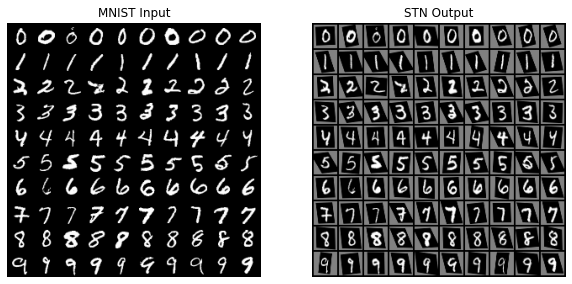

In [19]:
import os
import numpy as np
import torch
import torchvision.utils as vutils
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

dir_result = './results/stn/mnist/images'
lst_result = os.listdir(dir_result)

name_input = [f for f in lst_result if f.endswith('input.png')]
name_input_stn = [f for f in lst_result if f.endswith('input_stn.png')]

name_input.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
name_input_stn.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

dataset_test = datasets.MNIST(root='.', train=False, download=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0)

##
labels = loader_test.dataset.targets.numpy()

##
nx = 28
ny = 28
nch = 1

n = 10
m = 10

input = torch.zeros((n*m, ny, nx, nch))
input_stn = torch.zeros((n*m, ny, nx, nch))

for i in range(n):
    idx = np.where(labels == i)[0]
    np.random.shuffle(idx)
    for j in range(m):
        k = m * i + j
        input[k, :, :, :] = torch.from_numpy(plt.imread(os.path.join(dir_result, name_input[idx[j]]))[:, :, :nch])
        input_stn[k, :, :, :] = torch.from_numpy(plt.imread(os.path.join(dir_result, name_input_stn[idx[j]]))[:, :, :nch])

input = input.permute((0, 3, 1, 2))
input_stn = input_stn.permute((0, 3, 1, 2))

plt.figure(figsize=(n, m))

plt.subplot(121)
plt.imshow(np.transpose(vutils.make_grid(input, nrow=n, padding=2, normalize=True), (1, 2, 0)))
plt.axis('off')
plt.axis('image')
plt.title('MNIST Input')

plt.subplot(122)
plt.imshow(np.transpose(vutils.make_grid(input_stn, nrow=n, padding=2, normalize=True), (1, 2, 0)))
plt.axis('off')
plt.axis('image')
plt.title('STN Output')

plt.show()